<a href="https://colab.research.google.com/github/jwells52/creating-ai-enabled-systems/blob/main/Research%20Project/notebooks/fsl_experiment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install easyfsl

In [1]:
%pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 517.1 kB/s eta 0:00:00


### Download Humpback Whale Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/Research-Project/kaggle.json /root/.kaggle/kaggle.json && chmod 600 /root/.kaggle/kaggle.json && kaggle competitions download -c humpback-whale-identification

100% 5.50G/5.51G [04:56<00:00, 17.3MB/s]
100% 5.51G/5.51G [04:56<00:00, 20.0MB/s]


In [4]:
%%capture

!unzip humpback-whale-identification.zip

### Clone GitHub Repo

In [1]:
import os

if os.path.exists('/content/creating-ai-enabled-systems/Research Project') == False:
  !git clone https://github.com/jwells52/creating-ai-enabled-systems.git

%cd creating-ai-enabled-systems/Research\ Project

/content/creating-ai-enabled-systems/Research Project


### Imports

In [2]:
import os
import cv2
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from PIL import Image
from easyfsl.methods import PrototypicalNetworks, FewShotClassifier, SimpleShot, MatchingNetworks, RelationNetworks, TransductiveFinetuning
from easyfsl.utils import evaluate, evaluate_on_one_task
from easyfsl.samplers import TaskSampler

from torch import Tensor, nn
from torch.optim import SGD, Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34, resnet152

from typing import Callable

from modules.data_utils import HumpbackWhaleDataset, remove_new_whale_class, create_loader, transform
from modules.train import train_fsl, device


%load_ext autoreload
%autoreload 2

In [5]:
n_way   = 5
n_shot  = 5
n_query = 5

### Look at image characteristics for each quartile of accuracy

In [15]:
# Load into dataset
# For each class, calculate accuracy
# Then plot barplot of accuracy for each class
# Look at the characteristics of images for the classes that have low performance

In [6]:
df = remove_new_whale_class(
  pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/images_and_ids.csv')
)

df = df[df.class_count >= 10]

In [6]:
cnn = resnet18()
cnn.fc = torch.nn.Flatten()

few_shot_classifier = PrototypicalNetworks(cnn).to(device)
few_shot_classifier.load_state_dict(
  torch.load('/content/drive/MyDrive/Research-Project/models/prototypical_network_resnet18_prod_last_epoch')()
)

<All keys matched successfully>

In [18]:
%%capture

few_shot_classifier.eval()

In [26]:
task_images = {
    '<25%':   {'support_set': [], 'query_set': []},
    '25-50%': {'support_set': [], 'query_set': []},
    '50-75%': {'support_set': [], 'query_set': []},
    '>75%':   {'support_set': [], 'query_set': []}
}

n_tasks = 500
for task in tqdm(range(n_tasks)):
  ############################################
  # Create labels for supoprt & query set
  # Sample a random amount of n_way whale_ids
  ############################################
  whale_ids = np.random.choice(df['Id'].unique(), size=n_way, replace=False)

  #################################################################
  # Create support set
  # Sample n_shot images for each sampled whale_id
  #################################################################
  task_support_labels = []
  task_support_image_paths = []
  for i, whale_id in enumerate(whale_ids):
    task_support_image_paths.extend(list(np.random.choice(df[df['Id'] == whale_id]['Image'], size=5, replace=False)))
    task_support_labels.extend([i for _ in range(n_shot)])

  #############################################################
  # Create query set
  # Sample n_shot images for each sampled whale_id
  # These images CANNOT be in the support set already
  ##############################################################
  task_query_labels = []
  task_query_image_paths = []
  for i, whale_id in enumerate(whale_ids):
    whale_query_images = df[(df['Id'] == whale_id) & ~(df['Image'].isin(task_support_image_paths))]['Image']
    task_query_image_paths.extend(list(np.random.choice(whale_query_images, size=n_query, replace=False)))
    task_query_labels.extend([i for _ in range(n_query)])

  ###################################
  # Load images for support set
  ###################################
  support_images = np.zeros((n_shot*n_way, 3, 256, 512))
  for i, image_filename in enumerate(task_support_image_paths):
    support_images[i] = transform(Image.open(f'/content/train/{image_filename}')).detach().numpy()

  ###################################
  # Load images for query set
  ###################################
  query_images = np.zeros((n_query*n_way, 3, 256, 512))
  for i, image_filename in enumerate(task_query_image_paths):
    query_images[i] = transform(Image.open(f'/content/train/{image_filename}')).detach().numpy()


  # Turn all images and labels into tensors
  support_labels = torch.Tensor(task_support_labels)
  support_images = torch.Tensor(support_images)
  query_labels = torch.Tensor(task_query_labels)
  query_images = torch.Tensor(query_images)

  ################################################################
  # Make predictions on task with fine-tunes Prototypical Network
  ################################################################
  few_shot_classifier.process_support_set(support_images.to(device), support_labels.to(device))
  predictions = few_shot_classifier(query_images.to(device)).detach().data
  prediction_labels = torch.max(predictions, 1)[1].cpu().detach().data

  # Get classification accuracy for each whale_id in the task
  # And separate them into quartiles
  for label in torch.unique(query_labels):

    label_idxs = torch.argwhere(query_labels == label)
    whale_id_acc = (prediction_labels[label_idxs] == query_labels[label_idxs]).sum().item() / n_query
    whale_id = whale_ids[int(label.detach().item())]

    if whale_id_acc < 0.25:
      task_images['<25%']['support_set'] += [task_support_image_paths[i] for i in label_idxs]
      task_images['<25%']['query_set'] += [task_query_image_paths[i] for i in label_idxs]

    elif whale_id_acc >= 0.25 and whale_id_acc < 0.5:
      task_images['25-50%']['support_set'] += [task_support_image_paths[i] for i in label_idxs]
      task_images['25-50%']['query_set'] += [task_query_image_paths[i] for i in label_idxs]

    elif whale_id_acc >= 0.5 and whale_id_acc < 0.75:
      task_images['50-75%']['support_set'] += [task_support_image_paths[i] for i in label_idxs]
      task_images['50-75%']['query_set'] += [task_query_image_paths[i] for i in label_idxs]

    else:
      task_images['>75%']['support_set'] += [task_support_image_paths[i] for i in label_idxs]
      task_images['>75%']['query_set'] += [task_query_image_paths[i] for i in label_idxs]

100%|██████████| 500/500 [05:57<00:00,  1.40it/s]


In [ ]:
### Calculate the average width and height for images in each percentile
def get_image_stats(images, tqdm_desc):
  heights, widths = [], []
  red, green, blue = [], [], []
  for image_filename in tqdm(images, desc=tqdm_desc):
    image = cv2.imread(f'/content/train/{image_filename}')
    heights += [image.shape[0]]
    widths += [image.shape[1]]
    red += [np.mean(image[:, :, 2])]
    green += [np.mean(image[:, :, 1])]
    blue += [np.mean(image[:, :, 0])]

  return (
      np.mean(heights), np.std(heights),
      np.mean(widths), np.std(widths),
      np.mean(red), np.std(red),
      np.mean(green), np.std(green),
      np.mean(blue), np.std(blue)
  )

In [79]:
task_stats = {k: {} for k in task_images.keys()}
for percentile, sets in task_images.items():
  for s in sets.keys():
    (
      mean_height, std_height,
      mean_width, std_width,
      mean_red, std_red,
      mean_green, std_green,
      mean_blue, std_blue
    ) = get_image_stats(task_images[percentile][s], tqdm_desc=f'Processing {percentile} {s} images')
    task_stats[percentile][s] = {
        'height': {'mean': mean_height, 'std': std_height},
        'width': {'mean': mean_width, 'std': std_width},
        'red': {'mean': mean_red, 'std': std_red},
        'green': {'mean': mean_green, 'std': std_green},
        'blue': {'mean': mean_blue, 'std': std_blue}
    }

  print()

Processing <25% query_set: 100%|██████████| 30/30 [00:00<00:00, 81.91it/s]


Processing 25-50% query_set: 100%|██████████| 90/90 [00:01<00:00, 89.11it/s]


Processing 50-75% query_set: 100%|██████████| 450/450 [00:04<00:00, 104.88it/s]


Processing >75% query_set: 100%|██████████| 11930/11930 [01:53<00:00, 104.97it/s]

In [167]:
def plot_support_and_query_bars(ax, width, offset, support_info, query_info, support_label=None, query_label=None, support_color='blue', query_color='lightblue'):
  support_bar = ax.bar(offset, support_info, width, label=support_label, color=support_color)
  query_bar = ax.bar(offset+width, query_info, width, label=query_label, color=query_color)
  ax.bar_label(support_bar, padding=3)
  ax.bar_label(query_bar, padding=3)

def plot_support_and_query_errors(ax, support_x, support_y, support_error, query_x, query_y, query_error, color='lightgray', fmt='-'):
  ax.errorbar(support_x, support_y, yerr = support_error, color=color, fmt=fmt)
  ax.errorbar(query_x, query_y, yerr = query_error, color=color, fmt=fmt)

In [165]:
x = np.arange(4)
width = 0.3

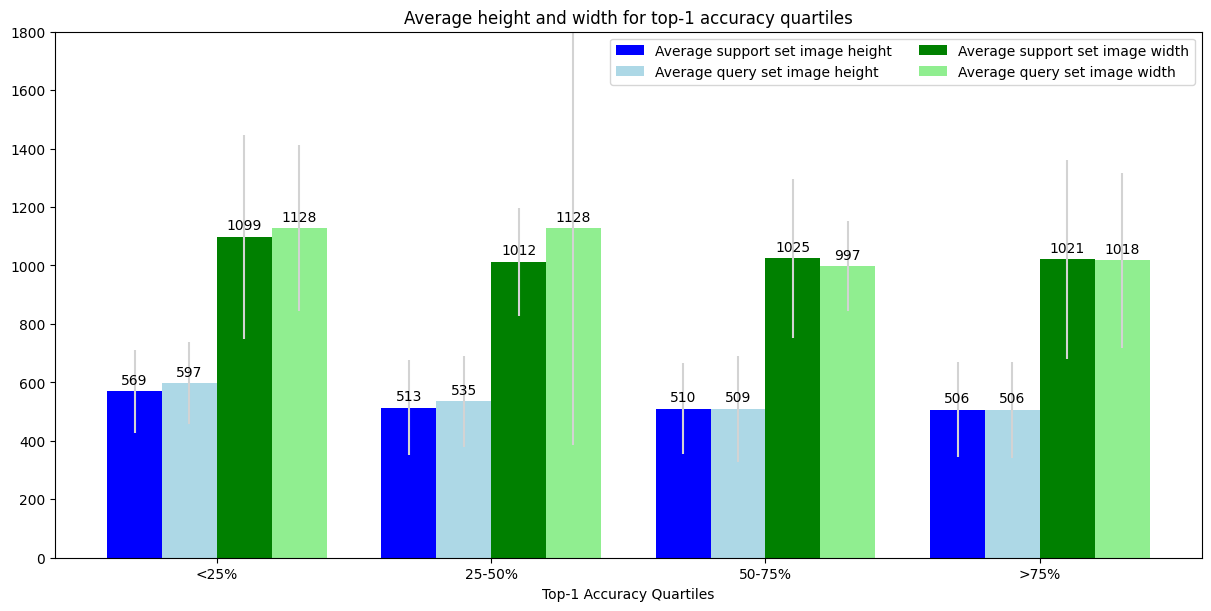

In [168]:
fig, ax = plt.subplots(layout='constrained', figsize=(12, 6))

support_label_height, query_label_height = 'Average support set image height', 'Average query set image height'
support_label_width, query_label_width = 'Average support set image width', 'Average query set image width'

offsets = []
i = 0
for percentile, stats in task_stats.items():
  (
      support_set_height_mean, query_set_height_mean,
      support_set_height_std, query_set_height_std,
      support_set_width_mean, query_set_width_mean,
      support_set_width_std, query_set_width_std
  ) = (
      round(stats['support_set']['height']['mean']), round(stats['query_set']['height']['mean']),
      round(stats['support_set']['height']['std']), round(stats['query_set']['height']['std']),
      round(stats['support_set']['width']['mean']), round(stats['query_set']['width']['mean']),
      round(stats['support_set']['width']['std']), round(stats['query_set']['width']['std'])
  )
  offset = width*i
  plot_support_and_query_bars(
    ax,
    width, offset,
    support_set_height_mean, query_set_height_mean,
    support_color='blue', query_color='lightblue',
    support_label=support_label_height, query_label=query_label_height
  )
  plot_support_and_query_errors(
    ax,
    width*i, support_set_height_mean, support_set_height_std,
    width*(i+1), query_set_height_mean, query_set_height_std
  )

  offset = width*(i+2)
  plot_support_and_query_bars(
    ax,
    width, offset,
    support_set_width_mean, query_set_width_mean,
    support_color='green', query_color='lightgreen',
    support_label=support_label_width, query_label=query_label_width
  )
  plot_support_and_query_errors(
    ax,
    width*(i+2), support_set_width_mean, support_set_width_std,
    width*(i+3), query_set_width_mean, query_set_width_std
  )

  support_label_height, query_label_height = None, None
  support_label_width, query_label_width = None, None

  offsets += [width*(i+1.5)]
  i += 5


ax.set_title('Average height and width for top-1 accuracy quartiles')
ax.set_xticks(offsets, list(task_stats.keys()))
ax.set_xlabel('Top-1 Accuracy Quartiles')
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 1800)
plt.show()
plt.show()

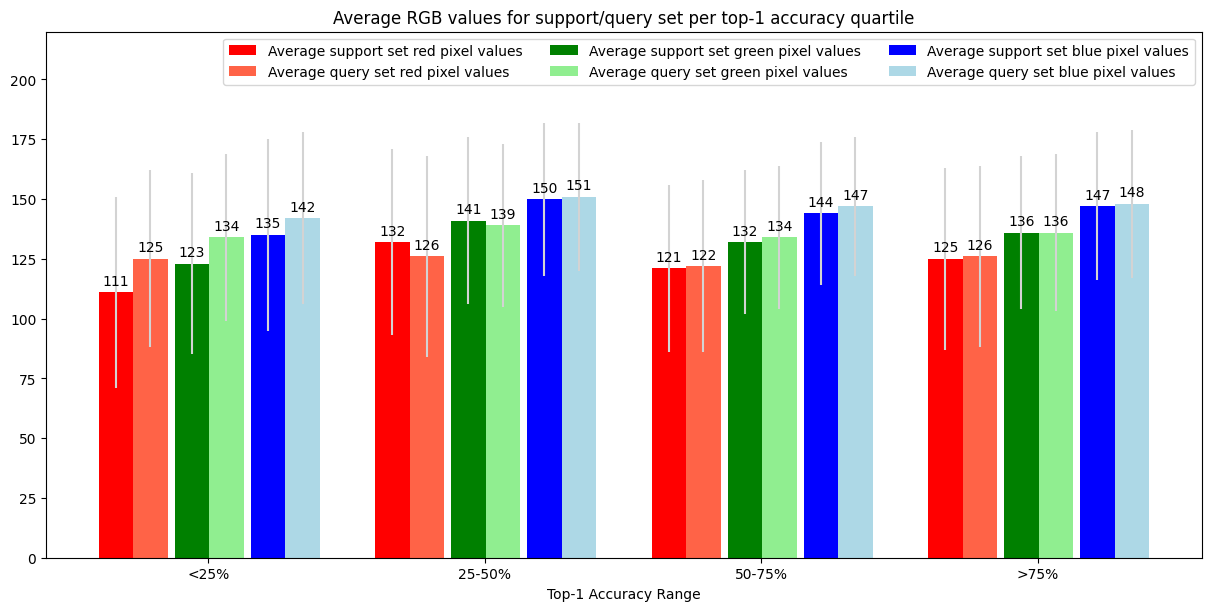

In [163]:
x = np.arange(4)
width = 0.30

fig, ax = plt.subplots(layout='constrained', figsize=(12, 6))

support_label_red, query_label_red = 'Average support set red pixel values', 'Average query set red pixel values'
support_label_green, query_label_green = 'Average support set green pixel values', 'Average query set green pixel values'
support_label_blue, query_label_blue = 'Average support set blue pixel values', 'Average query set blue pixel values'

offsets = []
i = 0
for percentile, stats in task_stats.items():
  (
      support_set_red_mean, query_set_red_mean,
      support_set_red_std, query_set_red_std,
      support_set_green_mean, query_set_green_mean,
      support_set_green_std, query_set_green_std,
      support_set_blue_mean, query_set_blue_mean,
      support_set_blue_std, query_set_blue_std,
  ) = (
      round(stats['support_set']['red']['mean']), round(stats['query_set']['red']['mean']),
      round(stats['support_set']['red']['std']), round(stats['query_set']['red']['std']),
      round(stats['support_set']['green']['mean']), round(stats['query_set']['green']['mean']),
      round(stats['support_set']['green']['std']), round(stats['query_set']['green']['std']),
      round(stats['support_set']['blue']['mean']), round(stats['query_set']['blue']['mean']),
      round(stats['support_set']['blue']['std']), round(stats['query_set']['blue']['std'])
  )

  offset = width*i
  plot_support_and_query_bars(
    ax,
    width, offset,
    support_set_red_mean, query_set_red_mean,
    support_color='red', query_color='tomato',
    support_label=support_label_red, query_label=query_label_red
  )
  plot_support_and_query_errors(
    ax,
    width*(i), support_set_red_mean, support_set_red_std,
    width*(i+1), query_set_red_mean, query_set_red_std
  )

  offset = width*(i+2.2)
  plot_support_and_query_bars(
    ax,
    width, offset,
    support_set_green_mean, query_set_green_mean,
    support_color='green', query_color='lightgreen',
    support_label=support_label_green, query_label=query_label_green
  )
  plot_support_and_query_errors(
    ax,
    width*(i+2.2), support_set_green_mean, support_set_green_std,
    width*(i+3.2), query_set_green_mean, query_set_green_std
  )


  offset = width*(i+4.4)
  plot_support_and_query_bars(
    ax,
    width, offset,
    support_set_blue_mean, query_set_blue_mean,
    support_color='blue', query_color='lightblue',
    support_label=support_label_blue, query_label=query_label_blue
  )
  plot_support_and_query_errors(
    ax,
    width*(i+4.4), support_set_blue_mean, support_set_blue_std,
    width*(i+5.4), query_set_blue_mean, query_set_blue_std
  )


  support_label_red, query_label_red = None, None
  support_label_green, query_label_green = None, None
  support_label_blue, query_label_blue = None, None

  offsets += [width*(i+2.67)]
  i += 8


ax.set_title('Average RGB values for support/query set per top-1 accuracy quartile')
ax.set_xticks(offsets, list(task_stats.keys()))
ax.set_xlabel('Top-1 Accuracy Range')
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 220)
plt.show()
plt.show()

# Look at different few shot learning metric-based networks

In [3]:
pretrained_cnn = resnet18(weights='DEFAULT')
pretrained_cnn.fc = torch.nn.Flatten()
pretrained_cnn = pretrained_cnn.to(device)

In [4]:
from torchvision.models.feature_extraction import create_feature_extractor

class FeatureExtractor(torch.nn.Module):
  def __init__(self, model, layer_name):
    super().__init__()
    self.model = model
    self.layer_name = layer_name

  def forward(self, x):
    return self.model(x)[self.layer_name]

layer = "layer4.1.bn2"
resnet_extractor = create_feature_extractor(pretrained_cnn, return_nodes=[layer])
feature_extractor = FeatureExtractor(resnet_extractor, layer)


In [7]:
dataset = HumpbackWhaleDataset('/content/train', df, transform=transform)

In [9]:
networks = {
    'Transductive Finetuning': TransductiveFinetuning(pretrained_cnn).to(device),
    'Relation Network': RelationNetworks(feature_extractor, feature_dimension=512).to(device),
    'Matching Network': MatchingNetworks(pretrained_cnn, feature_dimension=512).to(device),
    'Prototypical Network': PrototypicalNetworks(pretrained_cnn).to(device),
    'Simple Shot': SimpleShot(pretrained_cnn).to(device)
}

In [8]:
import time

In [10]:
n_tasks = 100
n_query = 5
ways = [5, 10, 20]
shots = [1, 3, 5]

accs = dict()
for network in networks:
  accs[network] = dict()
  for way in ways:
    accs[network][way] = {shot: np.nan for shot in shots}


for n_way in ways:
  for n_shot in shots:
    print(f'n_way = {n_way} | n_shot = {n_shot}')

    loader = create_loader(dataset, n_way, n_shot, n_query, 100, num_workers=12)
    for i, (name, network) in enumerate(networks.items()):
      print(f'Evaluating {name}:', end=' ')
      accs[name][n_way][n_shot] = evaluate(network, loader, device=device, use_tqdm=True)
      time.sleep(0.1)
    print()

n_way = 5 | n_shot = 1
Evaluating Transductive Finetuning: 

100%|██████████| 100/100 [00:11<00:00,  8.82it/s, accuracy=0.39]


Evaluating Relation Network: 

100%|██████████| 100/100 [00:09<00:00, 11.00it/s, accuracy=0.205]


Evaluating Matching Network: 

100%|██████████| 100/100 [00:08<00:00, 11.29it/s, accuracy=0.4]


Evaluating Prototypical Network: 

100%|██████████| 100/100 [00:08<00:00, 11.63it/s, accuracy=0.395]


Evaluating Simple Shot: 

100%|██████████| 100/100 [00:08<00:00, 11.20it/s, accuracy=0.42]


n_way = 5 | n_shot = 3
Evaluating Transductive Finetuning: 

100%|██████████| 100/100 [00:11<00:00,  9.03it/s, accuracy=0.546]


Evaluating Relation Network: 

100%|██████████| 100/100 [00:10<00:00,  9.71it/s, accuracy=0.214]


Evaluating Matching Network: 

100%|██████████| 100/100 [00:10<00:00,  9.32it/s, accuracy=0.52]


Evaluating Prototypical Network: 

100%|██████████| 100/100 [00:11<00:00,  8.90it/s, accuracy=0.528]


Evaluating Simple Shot: 

100%|██████████| 100/100 [00:11<00:00,  9.03it/s, accuracy=0.53]


n_way = 5 | n_shot = 5
Evaluating Transductive Finetuning: 

100%|██████████| 100/100 [00:13<00:00,  7.28it/s, accuracy=0.614]


Evaluating Relation Network: 

100%|██████████| 100/100 [00:13<00:00,  7.35it/s, accuracy=0.217]


Evaluating Matching Network: 

100%|██████████| 100/100 [00:13<00:00,  7.64it/s, accuracy=0.558]


Evaluating Prototypical Network: 

100%|██████████| 100/100 [00:13<00:00,  7.35it/s, accuracy=0.596]


Evaluating Simple Shot: 

100%|██████████| 100/100 [00:12<00:00,  7.71it/s, accuracy=0.604]


n_way = 10 | n_shot = 1
Evaluating Transductive Finetuning: 

100%|██████████| 100/100 [00:18<00:00,  5.54it/s, accuracy=0.284]


Evaluating Relation Network: 

100%|██████████| 100/100 [00:16<00:00,  5.92it/s, accuracy=0.105]


Evaluating Matching Network: 

100%|██████████| 100/100 [00:17<00:00,  5.85it/s, accuracy=0.262]


Evaluating Prototypical Network: 

100%|██████████| 100/100 [00:17<00:00,  5.64it/s, accuracy=0.279]


Evaluating Simple Shot: 

100%|██████████| 100/100 [00:17<00:00,  5.86it/s, accuracy=0.296]


n_way = 10 | n_shot = 3
Evaluating Transductive Finetuning: 

100%|██████████| 100/100 [00:21<00:00,  4.55it/s, accuracy=0.417]


Evaluating Relation Network: 

100%|██████████| 100/100 [00:21<00:00,  4.75it/s, accuracy=0.109]


Evaluating Matching Network: 

100%|██████████| 100/100 [00:21<00:00,  4.66it/s, accuracy=0.376]


Evaluating Prototypical Network: 

100%|██████████| 100/100 [00:20<00:00,  4.78it/s, accuracy=0.41]


Evaluating Simple Shot: 

100%|██████████| 100/100 [00:21<00:00,  4.75it/s, accuracy=0.413]


n_way = 10 | n_shot = 5
Evaluating Transductive Finetuning: 

100%|██████████| 100/100 [00:26<00:00,  3.80it/s, accuracy=0.48]


Evaluating Relation Network: 

100%|██████████| 100/100 [00:26<00:00,  3.77it/s, accuracy=0.107]


Evaluating Matching Network: 

100%|██████████| 100/100 [00:26<00:00,  3.80it/s, accuracy=0.446]


Evaluating Prototypical Network: 

100%|██████████| 100/100 [00:26<00:00,  3.81it/s, accuracy=0.487]


Evaluating Simple Shot: 

100%|██████████| 100/100 [00:26<00:00,  3.81it/s, accuracy=0.468]


n_way = 20 | n_shot = 1
Evaluating Transductive Finetuning: 

100%|██████████| 100/100 [00:35<00:00,  2.85it/s, accuracy=0.203]


Evaluating Relation Network: 

100%|██████████| 100/100 [00:33<00:00,  2.98it/s, accuracy=0.0502]


Evaluating Matching Network: 

100%|██████████| 100/100 [00:34<00:00,  2.93it/s, accuracy=0.196]


Evaluating Prototypical Network: 

100%|██████████| 100/100 [00:33<00:00,  2.99it/s, accuracy=0.194]


Evaluating Simple Shot: 

100%|██████████| 100/100 [00:33<00:00,  3.02it/s, accuracy=0.209]


n_way = 20 | n_shot = 3
Evaluating Transductive Finetuning: 

100%|██████████| 100/100 [00:42<00:00,  2.36it/s, accuracy=0.312]


Evaluating Relation Network: 

100%|██████████| 100/100 [00:42<00:00,  2.37it/s, accuracy=0.0548]


Evaluating Matching Network: 

100%|██████████| 100/100 [00:42<00:00,  2.38it/s, accuracy=0.286]

Evaluating Prototypical Network: 


100%|██████████| 100/100 [00:42<00:00,  2.37it/s, accuracy=0.312]


Evaluating Simple Shot: 

100%|██████████| 100/100 [00:42<00:00,  2.36it/s, accuracy=0.316]


n_way = 20 | n_shot = 5
Evaluating Transductive Finetuning: 

100%|██████████| 100/100 [00:53<00:00,  1.86it/s, accuracy=0.365]

Evaluating Relation Network: 


100%|██████████| 100/100 [00:52<00:00,  1.91it/s, accuracy=0.0544]

Evaluating Matching Network: 


100%|██████████| 100/100 [00:53<00:00,  1.87it/s, accuracy=0.335]


Evaluating Prototypical Network: 

100%|██████████| 100/100 [00:53<00:00,  1.86it/s, accuracy=0.365]

Evaluating Simple Shot: 


100%|██████████| 100/100 [00:52<00:00,  1.92it/s, accuracy=0.378]


In [15]:
from copy import deepcopy

In [16]:
accs

{'Transductive Finetuning': {5: {1: 0.3896, 3: 0.546, 5: 0.614},
  10: {1: 0.2844, 3: 0.417, 5: 0.48},
  20: {1: 0.2025, 3: 0.3118, 5: 0.3649}},
 'Relation Network': {5: {1: 0.2052, 3: 0.2144, 5: 0.2172},
  10: {1: 0.105, 3: 0.109, 5: 0.1066},
  20: {1: 0.0502, 3: 0.0548, 5: 0.0544}},
 'Matching Network': {5: {1: 0.4, 3: 0.5196, 5: 0.558},
  10: {1: 0.2624, 3: 0.376, 5: 0.4462},
  20: {1: 0.1955, 3: 0.2861, 5: 0.3346}},
 'Prototypical Network': {5: {1: 0.3948, 3: 0.528, 5: 0.5956},
  10: {1: 0.279, 3: 0.4102, 5: 0.487},
  20: {1: 0.1941, 3: 0.312, 5: 0.3653}},
 'Simple Shot': {5: {1: 0.42, 3: 0.5304, 5: 0.604},
  10: {1: 0.2956, 3: 0.4128, 5: 0.4676},
  20: {1: 0.2087, 3: 0.3162, 5: 0.3777}}}

In [23]:
accs_v2 = dict()

for network in accs.keys():
  accs_v2[network] = dict()
  for way in accs[network].keys():
    accs_v2[network][f'{way}-way'] = [acc for acc in accs[network][way].values()]

In [24]:
accs_v2

{'Transductive Finetuning': {'5-way': [0.3896, 0.546, 0.614],
  '10-way': [0.2844, 0.417, 0.48],
  '20-way': [0.2025, 0.3118, 0.3649]},
 'Relation Network': {'5-way': [0.2052, 0.2144, 0.2172],
  '10-way': [0.105, 0.109, 0.1066],
  '20-way': [0.0502, 0.0548, 0.0544]},
 'Matching Network': {'5-way': [0.4, 0.5196, 0.558],
  '10-way': [0.2624, 0.376, 0.4462],
  '20-way': [0.1955, 0.2861, 0.3346]},
 'Prototypical Network': {'5-way': [0.3948, 0.528, 0.5956],
  '10-way': [0.279, 0.4102, 0.487],
  '20-way': [0.1941, 0.312, 0.3653]},
 'Simple Shot': {'5-way': [0.42, 0.5304, 0.604],
  '10-way': [0.2956, 0.4128, 0.4676],
  '20-way': [0.2087, 0.3162, 0.3777]}}

In [28]:
accs_df = pd.DataFrame.from_dict(accs_v2).T
accs_df

,5-way,10-way,20-way
Transductive Finetuning,"[0.3896, 0.546, 0.614]","[0.2844, 0.417, 0.48]","[0.2025, 0.3118, 0.3649]"
Relation Network,"[0.2052, 0.2144, 0.2172]","[0.105, 0.109, 0.1066]","[0.0502, 0.0548, 0.0544]"
Matching Network,"[0.4, 0.5196, 0.558]","[0.2624, 0.376, 0.4462]","[0.1955, 0.2861, 0.3346]"
Prototypical Network,"[0.3948, 0.528, 0.5956]","[0.279, 0.4102, 0.487]","[0.1941, 0.312, 0.3653]"
Simple Shot,"[0.42, 0.5304, 0.604]","[0.2956, 0.4128, 0.4676]","[0.2087, 0.3162, 0.3777]"


In [57]:
accs_dict2 = dict()
for network, row in accs_df.iterrows():
  accs_dict2[network] = dict()
  for i, way in enumerate(row):
    for j, shot in enumerate(way):
      accs_dict2[network][f'{ways[i]}-way {shots[j]}-shot'] = shot

In [59]:
multi_columns = [(f'{n_way}-way', f'{n_shot}-shot') for n_way in ways for n_shot in shots]
multi_columns

[('5-way', '1-shot'),
 ('5-way', '3-shot'),
 ('5-way', '5-shot'),
 ('10-way', '1-shot'),
 ('10-way', '3-shot'),
 ('10-way', '5-shot'),
 ('20-way', '1-shot'),
 ('20-way', '3-shot'),
 ('20-way', '5-shot')]

In [60]:
accs_df2 = pd.DataFrame.from_dict(accs_dict2).T
accs_df2.columns = pd.MultiIndex.from_tuples(multi_columns)
accs_df2

5-way                  10-way                  \
                         1-shot  3-shot  5-shot  1-shot  3-shot  5-shot   
Transductive Finetuning  0.3896  0.5460  0.6140  0.2844  0.4170  0.4800   
Relation Network         0.2052  0.2144  0.2172  0.1050  0.1090  0.1066   
Matching Network         0.4000  0.5196  0.5580  0.2624  0.3760  0.4462   
Prototypical Network     0.3948  0.5280  0.5956  0.2790  0.4102  0.4870   
Simple Shot              0.4200  0.5304  0.6040  0.2956  0.4128  0.4676   

                         20-way                  
                         1-shot  3-shot  5-shot  
Transductive Finetuning  0.2025  0.3118  0.3649  
Relation Network         0.0502  0.0548  0.0544  
Matching Network         0.1955  0.2861  0.3346  
Prototypical Network     0.1941  0.3120  0.3653  
Simple Shot              0.2087  0.3162  0.3777